<a href="https://colab.research.google.com/github/monta0315/bokete/blob/main/bokete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Thu Aug 11 10:43:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

     |████████████████████████████████| 4.0 MB 35.3 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 101 kB 3.5 MB/s 
     |████████████████████████████████| 6.6 MB 54.9 MB/s 
     |████████████████████████████████| 880 kB 59.1 MB/s 
     |████████████████████████████████| 1.3 MB 32.9 MB/s 
     |████████████████████████████████| 4.1 MB 34.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [9]:
#画像データのzipを解凍します
!unzip /content/drive/MyDrive/Bokete/train.zip -d /content/train
!unzip /content/drive/MyDrive/Bokete/test.zip -d /content/test

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/test/felgzd9zk9.jpg  
  inflating: /content/test/bq82w6gfrh.jpg  
  inflating: /content/test/cgvsd330rq.jpg  
  inflating: /content/test/r5f687fbd5.jpg  
  inflating: /content/test/zkxdoyfjjl.jpg  
  inflating: /content/test/dqrsr5t5mz.jpg  
  inflating: /content/test/ejixnv3nsp.jpg  
  inflating: /content/test/fvpxarob5c.jpg  
  inflating: /content/test/e1dqq6fdrr.jpg  
  inflating: /content/test/zpdabksklo.jpg  
  inflating: /content/test/fnkq5comva.jpg  
  inflating: /content/test/dptz13yjas.jpg  
  inflating: /content/test/kawferdzhv.jpg  
  inflating: /content/test/cmckmjftu5.jpg  
  inflating: /content/test/xurlxnvlt0.jpg  
  inflating: /content/test/3juul9nfry.jpg  
  inflating: /content/test/ovnsqd35ir.jpg  
  inflating: /content/test/z8yeiuwgob.jpg  
  inflating: /content/test/ctsijbv1ek.jpg  
  inflating: /content/test/kydvsglfdt.jpg  
  inflating: /content/test/xayfclcaxw.jpg  
  inflating: /content/test/uutw6rfuob.jpg  


# Read Data
学習データと推論データについて、目的変数の分布などを確認していきます。

In [12]:
INPUT = "/content/drive/MyDrive/Bokete" # 所望のディレクトリに変更してください。
train_image_path = "/content/train/"
test_image_path = "/content/test/"

In [13]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [14]:
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 4)


,id,odai_photo_file_name,text,is_laugh
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0


test_data: (6000, 3)


,id,odai_photo_file_name,text
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...


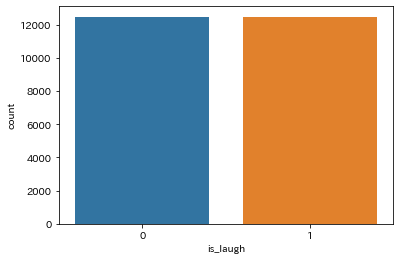

In [15]:
# 目的変数の分布を確認する
sns.countplot(x="is_laugh", data=train_df)

In [24]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [25]:
# 画像の重複があるか確認する
print(train_df["odai_photo_file_name"].duplicated().sum())
print(test_df["odai_photo_file_name"].duplicated().sum())

0
0


In [26]:
train_df.columns

Index(['id', 'odai_photo_file_name', 'text', 'is_laugh'], dtype='object')

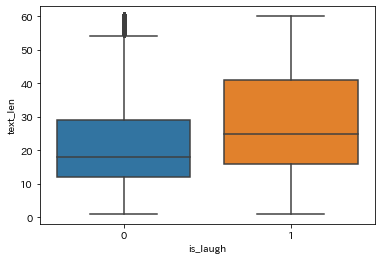

In [27]:
# 文書の長さとflagの関係を確認する
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()

sns.boxplot(x="is_laugh", y="text_len", data=train_df)